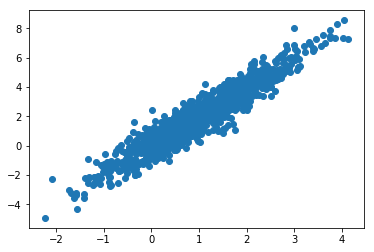

In [1]:
import numpy as np
from matplotlib import pyplot as plt

# Generate "real" data
X = np.random.normal(size=(1000, 2))
A = np.array([[1, 2], [-0.1, 0.5]])
b = np.array([1, 2])
X = np.dot(X,A) + b

# and stick them into an iterator
batch_size = 4

def iterate_minibatch(x, batch_size, shuffle=True):
    indices = np.arange(x.shape[0])
    if shuffle:
        np.random.shuffle(indices)
    
    for i in range(0, x.shape[0], batch_size):
        yield x[indices[i:i+batch_size], :]

plt.scatter(X[:, 0], X[:, 1])
plt.show()

In [2]:
"""
Define the network
reference:
1. https://github.com/zackchase/mxnet-the-straight-dope/blob/master/P10-C01-gan-intro.ipynb
2. https://github.com/carpedm20/DCGAN-tensorflow
"""

import tensorflow as tf


class GAN(object):
    def __init__(self):
        
        # input, output
        self.z = tf.placeholder(tf.float32, shape=[None, 2], name='z')
        self.x = tf.placeholder(tf.float32, shape=[None, 2], name='real_x')
        
        # define the network
        self.fake_x = self.netG(self.z)
        self.real_logits = self.netD(self.x, reuse=False)
        self.fake_logits = self.netD(self.fake_x, reuse=True)
        
        # define losses
        self.loss_D = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.real_logits,
                                                                            labels=tf.ones_like(self.real_logits))) + \
                      tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.fake_logits,
                                                                            labels=tf.zeros_like(self.real_logits)))
        self.loss_G = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.fake_logits,
                                                                            labels=tf.ones_like(self.real_logits)))
        
        # collect variables
        t_vars = tf.trainable_variables()
        self.d_vars = [var for var in t_vars if 'd_' in var.name]
        self.g_vars = [var for var in t_vars if 'g_' in var.name]
    
    def netG(self, z):
        """1-layer fully connected network"""

        with tf.variable_scope("generator") as scope:
            
            W = tf.get_variable(name="g_W", shape=[2, 2],
                                initializer=tf.contrib.layers.xavier_initializer(),
                                trainable=True)
            b = tf.get_variable(name="g_b", shape=[2],
                                initializer=tf.zeros_initializer(),
                                trainable=True)
            return tf.matmul(z, W) + b
        
    def netD(self, x, reuse=False):
        """3-layer fully connected network"""
        with tf.variable_scope("discriminator") as scope:
            if reuse:
                scope.reuse_variables()
         
            W1 = tf.get_variable(name="d_W1", shape=[2, 5],
                                initializer=tf.contrib.layers.xavier_initializer(),
                                trainable=True)
            b1 = tf.get_variable(name="d_b1", shape=[5],
                                initializer=tf.zeros_initializer(),
                                trainable=True)
            W2 = tf.get_variable(name="d_W2", shape=[5, 3],
                                initializer=tf.contrib.layers.xavier_initializer(),
                                trainable=True)
            b2 = tf.get_variable(name="d_b2", shape=[3],
                                initializer=tf.zeros_initializer(),
                                trainable=True)
            W3 = tf.get_variable(name="d_W3", shape=[3, 1],
                                initializer=tf.contrib.layers.xavier_initializer(),
                                trainable=True)
            b3 = tf.get_variable(name="d_b3", shape=[1],
                                initializer=tf.zeros_initializer(),
                                trainable=True)
            
            layer1 = tf.nn.tanh(tf.matmul(x, W1) + b1)
            layer2 = tf.nn.tanh(tf.matmul(layer1, W2) + b2)
            return tf.matmul(layer2, W3) + b3         


discriminator loss at epoch 0: 1.224059

discriminator accuracy at epoch 0: 0.595000


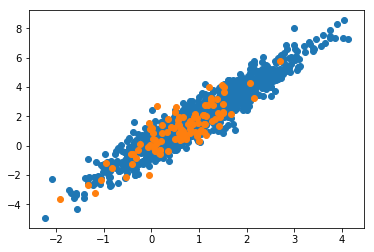


discriminator loss at epoch 1: 1.386383

discriminator accuracy at epoch 1: 0.550000


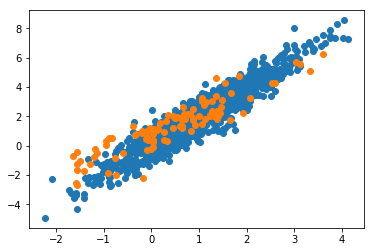


discriminator loss at epoch 2: 1.384361

discriminator accuracy at epoch 2: 0.495000


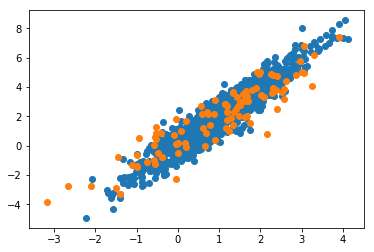


discriminator loss at epoch 3: 1.386762

discriminator accuracy at epoch 3: 0.505000


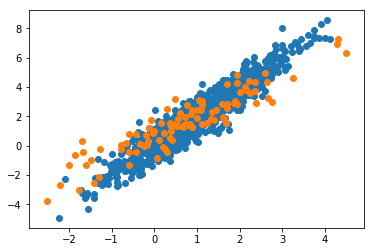


discriminator loss at epoch 4: 1.387769

discriminator accuracy at epoch 4: 0.510000


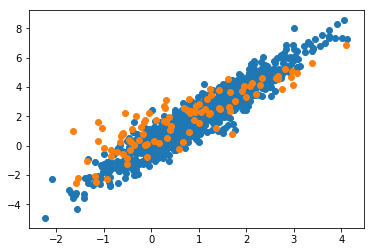


discriminator loss at epoch 5: 1.385907

discriminator accuracy at epoch 5: 0.540000


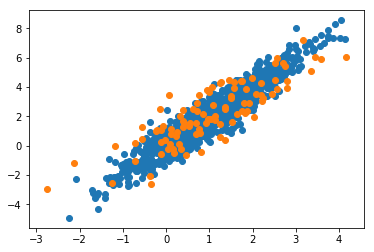


discriminator loss at epoch 6: 1.387779

discriminator accuracy at epoch 6: 0.505000


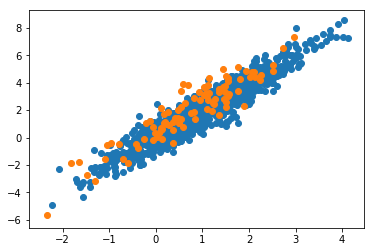


discriminator loss at epoch 7: 1.386505

discriminator accuracy at epoch 7: 0.510000


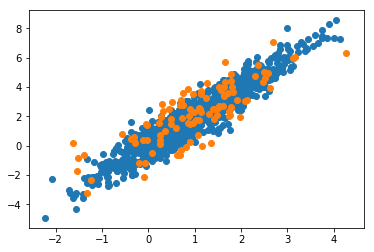


discriminator loss at epoch 8: 1.393429

discriminator accuracy at epoch 8: 0.495000


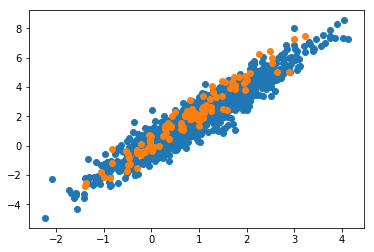


discriminator loss at epoch 9: 1.385764

discriminator accuracy at epoch 9: 0.495000


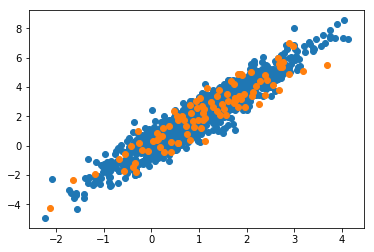

In [3]:
# Training loop
gan = GAN()
d_optim = tf.train.AdamOptimizer(learning_rate=0.05).minimize(gan.loss_D, var_list=gan.d_vars)
g_optim = tf.train.AdamOptimizer(learning_rate=0.01).minimize(gan.loss_G, var_list=gan.g_vars)

init = tf.global_variables_initializer()

config = tf.ConfigProto(device_count = {'GPU': 0})
with tf.Session(config=config) as sess:
    sess.run(init)
    
    for epoch in range(10):
        avg_loss = 0.
        count = 0
        for x_batch in iterate_minibatch(X, batch_size=batch_size):
            
            # generate noise z
            z_batch = np.random.normal(size=(4, 2))
            
            # update D network
            loss_D, _ = sess.run([gan.loss_D, d_optim],
                                feed_dict={
                                    gan.z: z_batch,
                                    gan.x: x_batch,
                                })
            
            # update G network
            loss_G, _ = sess.run([gan.loss_G, g_optim],
                                feed_dict={
                                    gan.z: z_batch,
                                    gan.x: np.zeros(z_batch.shape),    # dummy input
                                })
            
            avg_loss += loss_D
            count += 1
            
        avg_loss /= count
        z = np.random.normal(size=(100, 2))
        excerpt = np.random.randint(1000, size=100)
        fake_x, real_logits, fake_logits = sess.run([gan.fake_x, gan.real_logits, gan.fake_logits],
                         feed_dict={gan.z: z, gan.x: X[excerpt,:]})
        accuracy = 0.5 * (np.sum(real_logits>0) / 100. + np.sum(fake_logits<0) / 100.)
        print('\ndiscriminator loss at epoch %d: %f' % (epoch, avg_loss))
        print('\ndiscriminator accuracy at epoch %d: %f' % (epoch, accuracy))
        plt.scatter(X[:, 0], X[:, 1])
        plt.scatter(fake_x[:, 0], fake_x[:, 1])
        plt.show()